# Summary

## Objective

Understand the performance of `Calculator.zero_angle()` and get it working as well as possible.  The "cost" of a method is the number of iterations, because each iteration requires computing a trajectory, and that is by far the most computationally expensive operation involved.

We will:

0. Define a standard long-range rifle round to use throughout the study.
1. Compute the "reachable range" of the shot for launch angles from 0 to 90 degrees using `calc.find_max_range()`.  (This region is a convex hull.)
2. Sample target points within the reachable range and, for each point, determine how long it takes `.zero_angle()` to return the firing solution (i.e., the launch angle for a trajectory that will hit the point), and where it is unable to find a solution.

During the study we will use SciPy, but our goal is to have a `.zero_angle()` method that does not depend on SciPy and that can:
*  Calculate the zero angle for as large a region as possible, and 
*  Know where it won't work well – or at all.

(Note that in the `SciPyIntegrationEngine` the `._zero_angle()` method falls back on `._find_zero_angle()`, which uses SciPy's `root_scalar`.)

## Conclusions

* The current implementation can solve for targets out to about 85% of the maximum range in less than a dozen iterations: see [this chart](#plot-baseline-huge).  Beyond that it soon struggles and takes more than 20 iterations to converge, and right at the range limit it doesn't converge in less than 50 iterations.
  * However there are anomalies: within the region of good performance there are a scattered points (a few dozen out of 20,000 sampled) where it took an extraordinary number of iterations to converge, and _those exceptions need to be investigated_.
* Confirming that a target is in range using SciPy `.minimize_scalar()` (called through `scipy_engine.find_max_range()`) takes on average a dozen iterations, but as many as 26.  [There is a strange slice about the look angle 21° where it consistently takes more than 20 iterations](#find_max_range), and it would be interesting to know why.
  * Having paid the price to find the max-range for a look angle as well as the launch angle to reach that, SciPy `.root_scalar(method='brentq')` [can find the zero in less than 10 iterations on average](#zero-knowing-max_range_angle).
* If we know (or are willing to assert) that a target is in range, Newton's method (SciPy `.root_scalar(method='newton')` started at the look-angle) is a reliable performer, [finding the solution in 12 iterations over almost the entire reachable range](#newtons-method-big-sample).

# Load

**Note extra Python package dependencies:**
* plotly
* shapely
* tqdm

In [1]:
import logging
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
from shapely.geometry import Point, Polygon
from py_ballisticcalc import Ammo, Atmo, Calculator, HitResult, Shot
from py_ballisticcalc import RangeError, TrajFlag, BaseEngineConfigDict, SciPyEngineConfigDict
from py_ballisticcalc import TableG7, logger, loadMetricUnits, ZeroFindingError
from py_ballisticcalc.drag_model import DragModel
from py_ballisticcalc.helpers import must_fire
from py_ballisticcalc.unit import *
logger.setLevel(logging.WARNING)
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
PreferredUnits.distance = Distance.Meter

def create_shot():
    """This is a standard 7.62mm NATO shot."""
    dm = DragModel(0.22, TableG7, Weight.Gram(10), Distance.Centimeter(7.62), Distance.Centimeter(3.0))
    ammo = Ammo(dm, Velocity.MPS(800))
    return Shot(ammo=ammo, atmo=Atmo.icao())
shot = create_shot()
calc = Calculator(engine="scipy_engine")

## Example

In [2]:
# Here's how to get the max range at a particular slant angle
shot.slant_angle = Angular.Degree(15)
max_range, angle_to_reach = calc.find_max_range(shot)
print(f"Max range for target at look-angle {shot.slant_angle >> Angular.Degree:.2f}° "
      f"is {max_range >> Distance.Meter:.2f}m. Launch angle to hit is {angle_to_reach >> Angular.Degree:.2f}°.")

Max range for target at look-angle 15.00° is 3901.71m. Launch angle to hit is 43.44°.


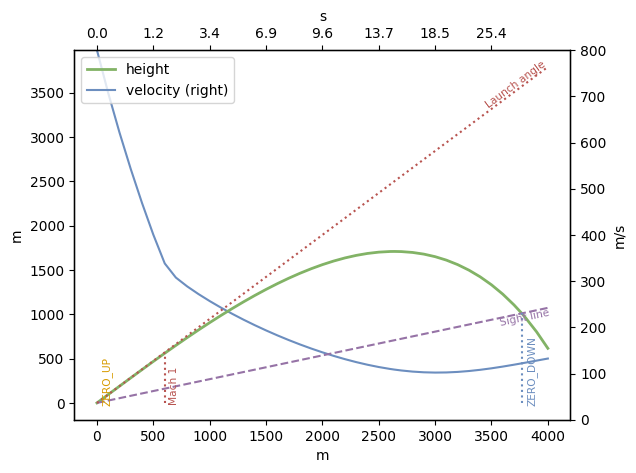

In [3]:
# Confirm the finding:
shot.barrel_elevation = angle_to_reach
trajectory, e = must_fire(calc, shot, trajectory_range=Distance.Meter((max_range >> Distance.Meter)+100), trajectory_step=Distance.Meter(100), extra_data=True)
trajectory.plot()
# Slant height at the target distance should be approximately zero (within a small tolerance)
slant_zero = trajectory.flag(TrajFlag.ZERO_DOWN)
assert abs(slant_zero.slant_distance.raw_value - max_range.raw_value) < 1e-6
assert abs(slant_zero.slant_height.raw_value) < 1e-6 

# Find Reachable Range Envelope
For slant angles from 0-90°.

In [4]:
# Calculate the max range for a variety of slant angles to map the envelope.
slant_angles_deg = np.linspace(0, 90, 91)
envelope_points = []
shot = create_shot()
for slant_angle_deg in tqdm(slant_angles_deg, desc="Slant angles"):
    shot.slant_angle = Angular.Degree(slant_angle_deg)
    try:
        max_dist, launch_angle = calc.find_max_range(shot)
        
        slant_angle_rad = shot.slant_angle >> Angular.Radian
        x = (max_dist >> Distance.Meter) * math.cos(slant_angle_rad)
        y = (max_dist >> Distance.Meter) * math.sin(slant_angle_rad)
        
        envelope_points.append({
            'slant_angle_deg': slant_angle_deg,
            'launch_angle_deg': launch_angle >> Angular.Degree,
            'max_dist_m': max_dist >> Distance.Meter,
            'x': x,
            'y': y
        })
    except Exception as e:
        print(f"Could not determine range for slant angle {slant_angle_deg:.1f}: {e}")

envelope_df = pd.DataFrame(envelope_points)
display(envelope_df.head())
display(envelope_df.tail())
# --- Visualize the envelope ---
fig = px.line(
    envelope_df.sort_values('slant_angle_deg'), 
    x='x', 
    y='y', 
    title='Reachable Range Envelope',
    labels={'x': 'Horizontal Distance (m)', 'y': 'Vertical Distance (m)'},
    hover_data=['slant_angle_deg', 'launch_angle_deg', 'max_dist_m']
)
fig.update_layout(
    yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
    xaxis=dict(constrain='domain'),
    title_x=0.5,
    margin=dict(t=50)
)
fig.show()

Slant angles:   0%|          | 0/91 [00:00<?, ?it/s]

,slant_angle_deg,launch_angle_deg,max_dist_m,x,y
0,0.0,35.917251,4342.467980,4342.467980,0.000000
1,1.0,36.384966,4307.781751,4307.125655,75.181158
2,2.0,36.857060,4273.950320,4271.346745,149.158715
3,3.0,37.335156,4240.949794,4235.137719,221.954163
4,4.0,37.816928,4208.744156,4198.491866,293.587151


,slant_angle_deg,launch_angle_deg,max_dist_m,x,y
86,86.0,87.367315,3143.251126,2.192621e+02,3135.594324
87,87.0,88.025528,3142.488487,1.644651e+02,3138.181816
88,88.0,88.683571,3141.935598,1.096520e+02,3140.021616
89,89.0,89.341752,3141.590724,5.482832e+01,3141.112245
90,90.0,90.000000,3141.485247,1.923605e-13,3141.485247


In [5]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(
    envelope_df,
    x='slant_angle_deg',
    y='launch_angle_deg',
    title='Launch Angle vs Slant Angle',
    labels={'slant_angle_deg': 'Slant Angle (deg)', 'launch_angle_deg': 'Launch Angle (deg)'}
)

# Add a chord (straight line) connecting the first and last points
fig.add_trace(go.Scatter(
    x=[envelope_df['slant_angle_deg'].iloc[0], envelope_df['slant_angle_deg'].iloc[-1]],
    y=[envelope_df['launch_angle_deg'].iloc[0], envelope_df['launch_angle_deg'].iloc[-1]],
    mode='lines',
    line=dict(color='red', dash='dash'),
    showlegend=False,
))
fig.show()

# Define sample region

In [6]:
def get_sample_points(envelope_df, min_distance: float=500, lin_density: int=50, extreme_only: bool=False):
    """Generate sample points within the reachable range envelope."""
    # Create a polygon from the envelope
    x_min, x_max = 0., envelope_df['x'].max()
    y_min, y_max = 0., envelope_df['y'].max()
    if extreme_only:  # Only cover points outside the chord
        envelope = envelope_df[['x', 'y']].values
    else:
        envelope = np.vstack([[0, -1], envelope_df[['x', 'y']].values])
    envelope_polygon = Polygon(envelope)

    x_points = np.linspace(x_min, x_max, lin_density)
    y_points = np.linspace(y_min, y_max, lin_density)
    test_points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1, 2)

    # Filter points that are inside the envelope
    use_points = []
    for p in test_points:
        point = Point(p)
        if point.within(envelope_polygon) and point.distance(Point(0,0)) > min_distance:
            use_points.append({'x': p[0], 'y': p[1]})

    return use_points

def plot_sample_points(envelope_df, point_list):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=envelope_df['x'], y=envelope_df['y'], mode='lines', name='Envelope', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=point_list['x'], y=point_list['y'], mode='markers', name='Test Points', marker=dict(size=2)))
    fig.update_layout(
        title=str(len(point_list))+' Selected Test Points within Envelope',
        yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
        xaxis=dict(constrain='domain', range=[0, envelope_df['x'].max()]),
        title_x=0.5,
        margin=dict(t=50)
    )
    fig.show()

## Small Sample (400 pts)

In [7]:
small_sample = get_sample_points(envelope_df, min_distance=2000, lin_density=30)
plot_sample_points(envelope_df, pd.DataFrame(small_sample))

## Big Sample (5,000 pts)

In [8]:
big_sample = get_sample_points(envelope_df, min_distance=565, lin_density=86)
plot_sample_points(envelope_df, pd.DataFrame(big_sample))

## Huge Sample (20,000 pts)

In [9]:
huge_sample = get_sample_points(envelope_df, min_distance=0, lin_density=169)
plot_sample_points(envelope_df, pd.DataFrame(huge_sample))

# Baseline

## Engine Constraints

The iterative zeroing algorithm takes a test shot (starting with launch angle equal to the slant angle to the target), observes how far the projectile was from the target when it reached the slant distance, and then calculates an adjustment based on that.  If the calculator isn't allowed to compute the trajectory all the way to the slant distance then it starts in a degraded state.  (And if we set `cMaximumDrop=0` then the `zero()` method can't even get started and will fail.)  To avoid this, let's check how much drop we need to allow the calculator to see in the most extreme case.

_When we launch at a look angle of zero: How far do we drop before reaching max horizontal distance of this projectile?_

In [10]:
max_x_m = envelope_df.x.max()
max_x = Distance.Meter(max_x_m)
max_x_ft = max_x >> Distance.Foot
conf = BaseEngineConfigDict(
    cMinimumVelocity=0,
    cMinimumAltitude=-max_x_ft/2.0,
    cMaximumDrop=max_x_ft/2.0,
)
calc = Calculator(config=conf, engine="scipy_engine")
t, e = must_fire(calc, create_shot(), trajectory_range=max_x, trajectory_step=max_x)
if e is not None:
    print(f"Error: {e}")
print(f'Max horizontal range is {max_x_m:.2f}m.  Launching at 0°, when trajectory x={t[-1].distance >> Distance.Meter:.2f}m, y={t[-1].height >> Distance.Meter:.2f}m')

Max horizontal range is 4342.47m.  Launching at 0°, when trajectory x=4342.47m, y=-2078.12m


Conclusion: **On the longest possible shot, when launch from the look-angle to the target, we can get a trajectory that reaches the target horizontal distance if calculator is allowed to drop half of the horizontal distance.**  This is the heuristic we'll use for setting the `cMaximumDrop` here.

## Define Zero Test Function

In [11]:
def zero_test(x_m: float, y_m: float, max_iterations: int=50,
              cZeroFindingAccuracy: float=0.000005, sensitivity_limit: float=-0.5, calc_config=None):
    target_dist = Distance.Meter(math.sqrt(x_m**2 + y_m**2))
    slant_range_ft = target_dist >> Distance.Foot
    slant_angle_rad = math.atan2(y_m, x_m)
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle

    target_x_ft = Distance.Meter(x_m) >> Distance.Foot
    iterations_count = 0
    range_error_ft = 9e9  # Absolute value of error from target distance along sight line
    prev_range_error_ft = 9e9
    prev_height_error_ft = 9e9
    damping_factor = 1.0  # Start with no damping
    damping_rate = 0.7  # Damping rate for correction
    last_correction = 0.0
    height_error_ft = cZeroFindingAccuracy * 2  # Absolute value of error from sight line in feet at zero distance
    warned = False
    sensitive = []  # Record sensitive values encountered
    damping = []  # Record damping values applied

    if calc_config is None:
        calc_config = BaseEngineConfigDict(
            cMinimumVelocity=0,
            cMinimumAltitude=-target_x_ft/2.0,
            cMaximumDrop=target_x_ft/2.0,
        )
    calc = Calculator(config=calc_config, engine="scipy_engine")
    props = calc._init_trajectory(shot)

    while iterations_count < max_iterations:
        iterations_count += 1
        try:
            t = calc._integrate(props, target_x_ft, target_x_ft, filter_flags=TrajFlag.NONE)[-1]
            height_diff_ft = t.slant_height >> Distance.Foot
            look_dist_ft = t.slant_distance >> Distance.Foot
            range_diff_ft = look_dist_ft - slant_range_ft
            range_error_ft = math.fabs(range_diff_ft)
            height_error_ft = math.fabs(height_diff_ft)
            trajectory_angle = t.angle >> Angular.Radian  # Trajectory angle at target distance
            sensitivity = math.tan(props.barrel_elevation_rad - slant_angle_rad) * math.tan(trajectory_angle - slant_angle_rad)
            if sensitivity < sensitivity_limit:
                sensitive.append(sensitivity)
                if not warned:
                    logger.info(f"Sensitivity {sensitivity} critical for point ({x_m}, {y_m}) after {iterations_count} iterations")
                    warned = True
                denominator = look_dist_ft
            else:
                denominator = look_dist_ft * (1 + sensitivity)
            if abs(denominator) > 1e-9:
                correction = -height_diff_ft / denominator
            else:
                raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                      'Correction denominator is zero')

            if range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # We're still trying to reach zero_distance
                if range_error_ft > prev_range_error_ft - 1e-6:  # We're not getting closer to zero_distance
                    raise ZeroFindingError(range_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Distance non-convergent')
            elif height_error_ft > math.fabs(prev_height_error_ft):  # Error is increasing, we are diverging
                damping_factor *= damping_rate  # Apply damping to prevent overcorrection
                if damping_factor < 0.3:
                    raise ZeroFindingError(height_error_ft, iterations_count, Angular.Radian(props.barrel_elevation_rad),
                          'Error non-convergent')
                logger.info(f'Tightened damping factor to {damping_factor:.2f} for point ({x_m}, {y_m}) after {iterations_count} iterations')
                damping.append(damping_factor)
                props.barrel_elevation_rad -= last_correction  # Revert previous adjustment
                correction = last_correction
            elif damping_factor < 1.0:
                logger.info(f'Reseting damping factor to 1.0 at iteration {iterations_count}')
                damping_factor = 1.0

            prev_range_error_ft = range_error_ft
            prev_height_error_ft = height_error_ft

            if height_error_ft > cZeroFindingAccuracy or range_error_ft > calc.ALLOWED_ZERO_ERROR_FEET:
                # Adjust barrel elevation to reduce error at zero distance
                applied_correction = correction * damping_factor
                props.barrel_elevation_rad += applied_correction
                last_correction = applied_correction
            else:  # We are close enough to zero, stop iterating
                result = {
                    'x': x_m,
                    'y': y_m,
                    'iterations': iterations_count,
                    'solution': props.barrel_elevation_rad,
                    'sensitivity': sensitive,
                    'damping': damping,
                    'error': None
                }
                break
        except Exception as e:
            result = {
                'x': x_m,
                'y': y_m,
                'iterations': iterations_count,
                'solution': None,
                'sensitivity': sensitive,
                'damping': damping,
                'error': e
            }
            break
    if iterations_count >= max_iterations:
        result = {
            'x': x_m,
            'y': y_m,
            'iterations': iterations_count,
            'solution': None,
            'sensitivity': sensitive,
            'damping': damping,
            'error': 'Max iterations reached'
        }
    return result

## Define Visualization

In [12]:
def plot_test_results(df, envelope_df, show=True, legend=True, title_str='Iterations to find zero across Reachable Range'):
    fig = go.Figure()
    converged_df = df[df['solution'].notna()].copy()
    failed_df = df[df['solution'].isna()].copy()
    if not converged_df.empty:
        heatmap_data = converged_df.pivot_table(index='y', columns='x', values='iterations', aggfunc='mean')
        min_val = np.nanmin(heatmap_data.values)
        max_val = np.nanmax(heatmap_data.values)
        # Normalize color stops
        green_stop = (3 - min_val) / (max_val - min_val) if max_val != min_val else 0
        blue_stop = (20 - min_val) / (max_val - min_val) if max_val != min_val else 0
        red_stop = (50 - min_val) / (max_val - min_val) if max_val != min_val else 1
        # Clamp to [0, 1]
        green_stop = min(max(green_stop, 0), 1)
        blue_stop = min(max(blue_stop, 0), 1)
        red_stop = min(max(red_stop, 0), 1)
        colorscale = [
            [0.0, "#00FF00"],         # Green at min
            [green_stop, "#00FF00"],  # Green up to z=3
            [blue_stop, "#1212FF"],   # Blue at z=20
            [red_stop, "#FF0000"],    # Red at z=50
            [1.0, "#FF0000"]          # Red at max
        ]
        fig.add_trace(
            go.Heatmap(
                z=heatmap_data.values,
                x=heatmap_data.columns,
                y=heatmap_data.index,
                colorscale=colorscale,#[[0.0, "#00FF00"], [0.5, "#1212FF"], [1.0, "#FF0000"]],
                colorbar=dict(title='Iterations', x=.85),
                name='Converged',
                hoverongaps=False,
                hovertemplate='x: %{x}<br>y: %{y}<br>iterations: %{z}<extra></extra>'
            )
        )
    if not failed_df.empty:
        fig.add_trace(  # Add failed points, colored white
            go.Scatter(
                x=failed_df['x'],
                y=failed_df['y'],
                mode='markers',
                marker=dict(color='white', symbol='square', size=7, line=dict(color='black', width=1)),
                name='Failed to converge',
                hoverinfo='text',
                text=[f"x: {r['x']:.2f}<br>y: {r['y']:.2f}<br>{r['error']}" for i, r in failed_df.iterrows()]
            )
        )
    fig.add_trace(  # Add the reachable envelope
        go.Scatter(
            x=envelope_df['x'], 
            y=envelope_df['y'], 
            mode='lines', 
            name='Reachable Envelope',
            line=dict(color='black', width=2)
        )
    )
    fig.update_layout(
        title=title_str,
        xaxis_title='Horizontal Distance to Target (m)',
        yaxis_title='Vertical Distance to Target (m)',
        yaxis=dict(scaleanchor="x", scaleratio=1, dtick=1000),
        xaxis=dict(constrain='domain'),
        title_x=0.5,
        legend=dict(x=1, y=1, traceorder='normal', title_text='Result'),
        showlegend=True if legend else False,
        margin=dict(t=50)
    )
    if show:
        fig.show()
    return fig

## Baseline (small sample)

In [13]:
results = []
df = pd.DataFrame(small_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_small_df = pd.DataFrame(results)
baseline_small_df.to_csv('ZeroSmallBaseline.csv')

  0%|          | 0/404 [00:00<?, ?it/s]

### Plot Small Baseline

In [14]:
p = plot_test_results(baseline_small_df, envelope_df)
p.write_html('ZeroBaselineSmallChart.html')

In [15]:
# Check points with no solution
baseline_small_df[baseline_small_df['solution'].isna()]

,x,y,iterations,solution,sensitivity,damping,error
7,149.740275,2816.504014,14,NaN,[],[],Distance non-convergent. Vertical error 0.0137...
64,898.441651,3033.158169,50,NaN,[],[],Max iterations reached
238,2395.844403,2383.195704,50,NaN,"[-0.5720505598575796, -0.6145936418602207, -0....",[],Max iterations reached
260,2545.584678,2274.868627,50,NaN,"[-0.5011172197033307, -0.5610969634956718, -0....",[],Max iterations reached
281,2695.324953,2166.541549,50,NaN,"[-0.5998856477406131, -0.665295641427659, -0.7...",[],Max iterations reached
335,3144.545779,1733.233240,50,NaN,"[-0.5364972537017535, -0.6100281333829783, -0....",[],Max iterations reached
364,3444.026329,1408.252007,50,NaN,"[-0.7020134077820933, -0.7651133582381656, -0....",[],Max iterations reached
400,4042.987430,541.635387,50,NaN,"[-0.6245175406735637, -0.7915887052339943, -0....",[],Max iterations reached


## Baseline (big sample)

See how the current algorithm performes when the calculator is allowed sufficient drop to reach the target horizontal distance when launched at the slant angle.

In [16]:
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_big_df = pd.DataFrame(results)
baseline_big_df.to_csv('ZeroBigBaseline.csv')

  0%|          | 0/5005 [00:00<?, ?it/s]

### Plot

In [17]:
p = plot_test_results(baseline_big_df, envelope_df)
p.write_html('ZeroBaselineChart.html')

## Baseline (huge sample)

In [18]:
results = []
df = pd.DataFrame(huge_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y']))
baseline_huge_df = pd.DataFrame(results)
baseline_huge_df.to_csv('ZeroHugeBaseline.csv')

  0%|          | 0/20073 [00:00<?, ?it/s]

### Plot Baseline Huge

In [19]:
p = plot_test_results(baseline_huge_df, envelope_df)
p.write_html('ZeroBaselineHugeChart.html')

In [36]:
baseline_huge_df['iterations'].describe()

count    20073.000000
mean        10.294226
std          7.930109
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         50.000000
Name: iterations, dtype: float64

## Sensitivity Limit

What if we bound the sensitivity term at 0, instead of letting it go as low as -0.5?  It looks like this costs some extra iterations in a small slice approaching the maximum range at elevated look angles.

In [20]:
results = []
df = pd.DataFrame(small_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(zero_test(point['x'], point['y'], sensitivity_limit=0.0))
sensitivity_positive_df = pd.DataFrame(results)
sensitivity_positive_df.to_csv('ZeroSensitivityPositive.csv')
diff_df = sensitivity_positive_df[~sensitivity_positive_df.solution.isna()].copy()
diff_df['iterations'] -= baseline_small_df['iterations']
p = plot_test_results(diff_df, envelope_df, title_str='Extra iterations to find zero with sensitivity limit raised from -0.5 to 0.0')
p.write_html('ZeroSensitivityPositiveChart.html')

  0%|          | 0/404 [00:00<?, ?it/s]

# scipy_engine.find_zero_angle()

For comparison, how many trajectory calculations does `scipy_engine.find_zero_angle()` take?  We want to decompose the current version because it does two operations:

1. Calls `._find_max_range()` on the look-angle to the target.  This returns the maximum range along that look-angle as well as the max-launch-angle to hit it.  We use the maximum range to ensure that a solution exists to hit the target.  We use the max-launch-angle in the next step:
2. Runs SciPy's `root_scalar` with the `brentq` method to find the solution, using the angle to the max range found in step #1 to define the search bracket [slant-angle, max-launch-angle].

As we will see, the first step is relatively expensive.  If we want to skip the first step then we have two general problems:
1. We can't guarantee that the target is within range.
2. For every target inside the reachable envelope, there are two trajectories that can hit it.

Here we already know that we are only studying points that are within range of the shot.  However, to guarantee that we find the flatter of the two possible trajectories we can no longer use a method that requires a bracket.  (The most tricky points are near the vertical where the launch difference between the "lofted" and "flat" trajectories approaches zero.)  But we'll add an option to run Newton's method starting with the slant-angle, since the flat trajectory is always closer to that, and see how that does.

In [21]:
from scipy.optimize import root_scalar
def scipy_zero_test(x_m: float, y_m: float, check_in_range: bool=True, calc_config=None):
    target_dist = Distance.Meter(math.sqrt(x_m**2 + y_m**2))
    slant_range_ft = target_dist >> Distance.Foot
    slant_angle_rad = math.atan2(y_m, x_m)
    slant_angle = Angular.Radian(slant_angle_rad)
    shot = create_shot()
    shot.slant_angle = slant_angle

    target_x_ft = Distance.Meter(x_m) >> Distance.Foot
    target_y_ft = Distance.Meter(y_m) >> Distance.Foot
    if calc_config is None:
        calc_config = BaseEngineConfigDict(
            cMinimumVelocity=0,
            cMinimumAltitude=-target_x_ft/2.0,
            cMaximumDrop=target_x_ft/2.0,
        )
    calc = Calculator(config=calc_config, engine="scipy_engine")
    props = calc._init_trajectory(shot)
    start_count = calc.trajectory_count

    def error_at_distance(angle_rad: float) -> float:
        """Target miss (in feet) for launch at <angle_rad>."""
        props.barrel_elevation_rad = angle_rad
        # Integrate to find the projectile's state at the target's horizontal distance.
        t = calc._integrate(props, target_x_ft, target_x_ft, filter_flags=TrajFlag.NONE)[-1]
        if t.time == 0.0:
            logger.warning("Integrator returned initial point. Consider removing constraints.")
            return -1e6  # Large negative error to discourage this angle.
        # return -abs(t.slant_height >> Distance.Foot) - abs((t.slant_distance >> Distance.Foot) - slant_range_ft)
        return (t.height >> Distance.Foot) - target_y_ft - abs((t.distance >> Distance.Foot) - target_x_ft)

    if check_in_range:  # Current implementation, first calls find_max_range
        max_range, angle_at_max = calc._find_max_range(props)
        max_range_count = calc.trajectory_count
        angle_bracket = (props.look_angle_rad, angle_at_max >> Angular.Radian)
        try:
            sol = root_scalar(error_at_distance, bracket=angle_bracket, method='brentq')
            if not sol.converged:
                raise ValueError()
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'range_iterations': max_range_count - start_count,
                'zero_iterations': calc.trajectory_count - max_range_count,
                'solution': sol.root,
                'error': None
            }
            return result
        except ValueError as e:
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'range_iterations': max_range_count - start_count,
                'zero_iterations': calc.trajectory_count - max_range_count,
                'solution': None,
                'error': "No solution found"
            }
            return result
    else:  # Use Newton's method
        try:
            sol = root_scalar(error_at_distance, x0=slant_angle_rad, method='newton')
            if not sol.converged:
                raise ValueError()
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': sol.root,
                'error': None
            }
            return result
        except ValueError as e:
            result = {
                'x': point['x'],
                'y': point['y'],
                'iterations': calc.trajectory_count - start_count,
                'solution': None,
                'error': "No solution found"
            }
            return result

## Newton's method (small sample)

In [22]:
results = []
df = pd.DataFrame(small_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(scipy_zero_test(point['x'], point['y'], check_in_range=False))
newton_small_df = pd.DataFrame(results)    

  0%|          | 0/404 [00:00<?, ?it/s]

In [23]:
p = plot_test_results(newton_small_df, envelope_df, legend=False, title_str="Newton's method iterations to find zero")

In [24]:
# Confirm that it is finding the same points as the baseline
newton_small_df['chk'] = abs(newton_small_df['solution'] - baseline_small_df['solution'])
newton_small_df['chk'].sum()

np.float64(1.2138255368887574e-07)

## Newton's method (big sample)

In [25]:
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(scipy_zero_test(point['x'], point['y'], check_in_range=False))
newton_big_df = pd.DataFrame(results)
newton_big_df.to_csv('ZeroNewtonBig.csv')

  0%|          | 0/5005 [00:00<?, ?it/s]

In [26]:
p = plot_test_results(newton_big_df, envelope_df, legend=False, title_str="Newton's method iterations to find zero")
p.write_html('ZeroNewtonBigChart.html')

In [35]:
newton_big_df['iterations'].describe()

count    5005.000000
mean       12.638362
std         3.060652
min         9.000000
25%        12.000000
50%        12.000000
75%        12.000000
max       150.000000
Name: iterations, dtype: float64

## scipy_engine (big sample)

In [27]:
results = []
df = pd.DataFrame(big_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(scipy_zero_test(point['x'], point['y']))
scipy_big_df = pd.DataFrame(results)
scipy_big_df.to_csv('ZeroSciPy.csv')

  0%|          | 0/5005 [00:00<?, ?it/s]

### Plot

In [28]:
p = plot_test_results(scipy_big_df, envelope_df, legend=False)
p.write_html('ZeroSciPyChart.html')

## scipy_engine (huge sample)

In [29]:
results = []
df = pd.DataFrame(huge_sample)
for i, point in tqdm(df.iterrows(), total=len(df)):
    results.append(scipy_zero_test(point['x'], point['y']))
scipy_huge_df = pd.DataFrame(results)
scipy_huge_df.to_csv('ZeroSciPyHuge.csv')

  0%|          | 0/20073 [00:00<?, ?it/s]

### Plots

1. The first chart shows the iterations to for `.find_zero_angle()` with the current implementation, which begins by running `.find_max_range()` on the look-angle to the target point, to ensure that it is within range.
2. The second chart shows the iterations involved in just that `.find_max_range()` step.
3. The third chart shows the iterations to find the zero, given that we have verified it is in range, and exploiting the max-range-launch-angle to narrow the search bracket.

We see a curious artifact in the first two charts: for targets near the 21° look angle, `.find_max_range()` takes more iterations than for similar points at any other look angle.

In [30]:
p = plot_test_results(scipy_huge_df, envelope_df, legend=False, title_str="SciPy.find_zero_angle() iterations to find zero")
p.write_html('ZeroSciPyChartHuge.html')

#### find_max_range()

In [31]:
range_iterations_df = scipy_huge_df.copy()
range_iterations_df['iterations'] = range_iterations_df['range_iterations']
p_max_range = plot_test_results(range_iterations_df, envelope_df, show=False, title_str='Iterations to find max range for look angle')
ray_length = envelope_df['max_dist_m'].max()
# Add a line along the strange angle that takes more iterations to find the max range
angle_rad = 0.36
x_ray = ray_length * np.cos(angle_rad)
y_ray = ray_length * np.sin(angle_rad)
p_max_range.add_trace(go.Scatter(x=[0, x_ray], y=[0, y_ray],
    mode='lines', line=dict(color='black', width=2), name='Ray at 0.36 rad (21°)'
))

In [33]:
scipy_huge_df['range_iterations'].describe()

count    20073.000000
mean        11.871071
std          3.227648
min          7.000000
25%         10.000000
50%         11.000000
75%         13.000000
max         26.000000
Name: range_iterations, dtype: float64

#### Zero, knowing max_range_angle

In [32]:
zero_iterations_df = scipy_huge_df.copy()
zero_iterations_df['iterations'] = zero_iterations_df['zero_iterations']
p = plot_test_results(zero_iterations_df, envelope_df, legend=False, title_str='Iterations to find zero, knowing max range angle')

In [34]:
scipy_huge_df['zero_iterations'].describe()

count    20073.000000
mean         9.980621
std          2.814490
min          6.000000
25%          8.000000
50%          9.000000
75%         12.000000
max         32.000000
Name: zero_iterations, dtype: float64